In [1]:
import numpy as np

import matplotlib.pyplot as plt

from cca import synth_data

from cca import ComplexityComponentsAnalysis as CCA
from cca.cca import ortho_reg_fn

import torch
import torch.nn.functional as F

In [2]:
def norm_proj(proj):
    return proj / torch.norm(proj, dim=1, keepdim=True)

def transform(X, proj):
    """Project the data."""
    shape = X.shape[1:]
    Xp = torch.mm(proj, X.reshape(X.shape[0], -1))
    return Xp.reshape((-1,) + shape)

def make_norm_power(X):
    Y = F.unfold(X, kernel_size=[T_ent, 1], stride=100)
    Y = torch.transpose(Y, 1, 2)
    Yf = torch.rfft(Y, 1, onesided=True)
    Yp = torch.mean(Yf[:, :, :, 0]**2 + Yf[:, :, :, 1]**2, dim=1)
    return Yp / torch.norm(Yp, dim=1, keepdim=True)

def loss_fn(X, proj):
    projn = norm_proj(proj)
    Xp = transform(X, projn)
    YP = make_norm_power(Xp)
    ent = torch.log(YP).sum(dim=1).mean()
    reg = ortho_reg_fn(proj.t(), 1.)
    return ent + reg

In [3]:
channels = 40
T = 1000
T_ent = 100
d = 1

In [4]:
cov = np.diag(np.ones(channels)) * .2
X = synth_data.embed_lorenz_system(T, .005, .05, channels, cov)
X = X[100:]
X -= X.mean(axis=0, keepdims=True)
X = X.T[:, np.newaxis, :, np.newaxis]

In [5]:
# Need the unit dimensions for some of the torch functions
X = torch.Tensor(X)

proj = torch.randn(d, channels)
proj = norm_proj(proj).requires_grad_()

In [6]:
opt = torch.optim.SGD([proj], lr=.005, momentum=True)

tensor(-116.1150, grad_fn=<AddBackward0>)
tensor(-163.8561, grad_fn=<AddBackward0>)
tensor(-115.1189, grad_fn=<AddBackward0>)
tensor(-122.9775, grad_fn=<AddBackward0>)
tensor(-144.2081, grad_fn=<AddBackward0>)
tensor(-165.9185, grad_fn=<AddBackward0>)
tensor(-150.5107, grad_fn=<AddBackward0>)
tensor(-111.6798, grad_fn=<AddBackward0>)
tensor(-170.9183, grad_fn=<AddBackward0>)
tensor(-114.6225, grad_fn=<AddBackward0>)


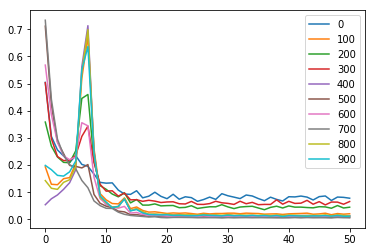

In [7]:
for ii in range(1000):
    opt.zero_grad()
    loss = loss_fn(X, proj)
    if (ii % 100) == 0:
        print(loss)
        projn = proj / torch.norm(proj, dim=1, keepdim=True)
        shape = X.shape[1:]
        Xp = torch.mm(projn, X.reshape(X.shape[0], -1))
        Xp = Xp.reshape((-1,) + shape)
        Yp = make_norm_power(Xp)
        plt.plot(Yp[0].detach().numpy(), label=ii)
    loss.backward()
    opt.step()
plt.legend()

In [8]:
r = np.squeeze(transform(X, norm_proj(proj)).detach().numpy())

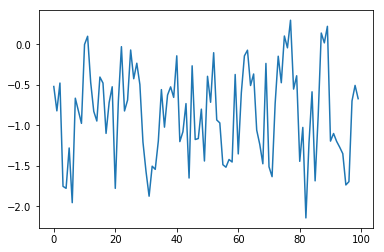

In [9]:
plt.plot(r[:100])

In [10]:
model = CCA(d, 5)

In [11]:
rc = model.fit_transform(np.squeeze(X.numpy()).T)

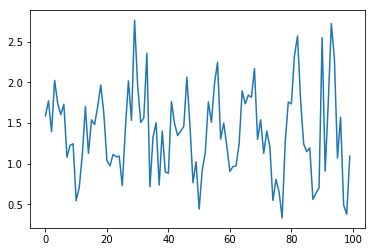

In [12]:
plt.plot(rc[:100])